In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
import os, cv2, json
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB4
from keras.optimizers import Adam
from tensorflow.keras import layers, models, callbacks, optimizers, applications, experimental, losses, utils
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc, f1_score, average_precision_score, precision_score, recall_score

#from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.applications import ResNet50, VGG16

from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

In [ ]:
ORI_DIR = os.getcwd()+"\ISIC_2008_challenge_3"
os.listdir(ORI_DIR)

['HAM10000_images',
 'HAM10000_metadata',
 'HAM10000_metadata.csv',
 'ISIC2018_Task3_Test_GroundTruth.csv',
 'ISIC2018_Task3_Test_Images',
 'ISIC2018_Task3_Validation_GroundTruth',
 'ISIC2018_Task3_Validation_GroundTruth.csv',
 'ISIC2018_Task3_Validation_Input']

In [ ]:
ori_train_images_dir =os.path.join(ORI_DIR, 'HAM10000_images')
ori_test_images_dir =os.path.join(ORI_DIR, 'ISIC2018_Task3_Test_Images')
train_metadata = os.path.join(ORI_DIR, 'HAM10000_metadata.csv')
test_metadata = os.path.join(ORI_DIR, 'ISIC2018_Task3_Test_GroundTruth.csv')

In [ ]:
print('Original Train images: %d' %len(os.listdir(ori_train_images_dir)))

Original Train images: 10015


In [ ]:
print('Original Test images: %d' %len(os.listdir(ori_test_images_dir)))

Original Test images: 1511


In [ ]:
dir = 'Processed_images'
PRO_DIR = os.path.join(os.getcwd(), dir)
MK_DIR = os.mkdir(PRO_DIR)
os.listdir(PRO_DIR)

[]

In [ ]:
train = 'train'
pro_train_images_dir = os.path.join(PRO_DIR, train)
os.mkdir(pro_train_images_dir)
os.listdir(pro_train_images_dir)

[]

In [ ]:
test = 'test'
pro_test_images_dir = os.path.join(PRO_DIR, test)
os.mkdir(pro_test_images_dir)
os.listdir(pro_test_images_dir)

[]

In [ ]:
print('Processed Train images: %d' %len(os.listdir(pro_train_images_dir)))

Processed Train images: 0


In [ ]:
print('Processed Test images: %d' %len(os.listdir(pro_test_images_dir)))

Processed Test images: 0


In [ ]:
def dull_razor(image, blackhat_kernel_size=(9, 9), gaussian_blur_size=(3, 3), threshold_value=10, inpainting_radius=6):

    # Convert to grayscale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply black hat filter with the given kernel size
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, blackhat_kernel_size)
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

    # Apply Gaussian blur with the given kernel size
    bhg = cv2.GaussianBlur(blackhat, gaussian_blur_size, cv2.BORDER_DEFAULT)

    # Apply binary thresholding to create a mask
    ret, mask = cv2.threshold(bhg, threshold_value, 255, cv2.THRESH_BINARY)

    # Use inpainting to remove the hair with the given radius
    dst = cv2.inpaint(image, mask, inpainting_radius, cv2.INPAINT_TELEA)

    return dst

def process_directory(input_dir, output_dir, blackhat_kernel_size=(9, 9), gaussian_blur_size=(3, 3), threshold_value=10, inpainting_radius=6):

    # Loop over all the files in the input directory
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):

            # Read the image
            img_path = os.path.join(input_dir, filename)
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)

            if image is None:
                continue

            # Apply the Dull Razor algorithm with the specified parameters
            processed_image = dull_razor(
                image,
                blackhat_kernel_size=blackhat_kernel_size,
                gaussian_blur_size=gaussian_blur_size,
                threshold_value=threshold_value,
                inpainting_radius=inpainting_radius
            )

            # Save the processed image to the output directory
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, processed_image)


In [ ]:

# Train data
input_directory = ori_train_images_dir
output_directory = pro_train_images_dir

blackhat_kernel_size = (7, 7)
gaussian_blur_size = (5, 5)
threshold_value = 15
inpainting_radius = 5

process_directory(
    input_dir=input_directory,
    output_dir=output_directory,
    blackhat_kernel_size=blackhat_kernel_size,
    gaussian_blur_size=gaussian_blur_size,
    threshold_value=threshold_value,
    inpainting_radius=inpainting_radius
)


In [ ]:

# Test data
input_directory = ori_test_images_dir
output_directory = pro_test_images_dir

# Parameters to tune
blackhat_kernel_size = (7, 7)
gaussian_blur_size = (5, 5)
threshold_value = 15
inpainting_radius = 5

process_directory(
    input_dir=input_directory,
    output_dir=output_directory,
    blackhat_kernel_size=blackhat_kernel_size,
    gaussian_blur_size=gaussian_blur_size,
    threshold_value=threshold_value,
    inpainting_radius=inpainting_radius
)


In [ ]:
train_df = pd.read_csv(train_metadata)
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


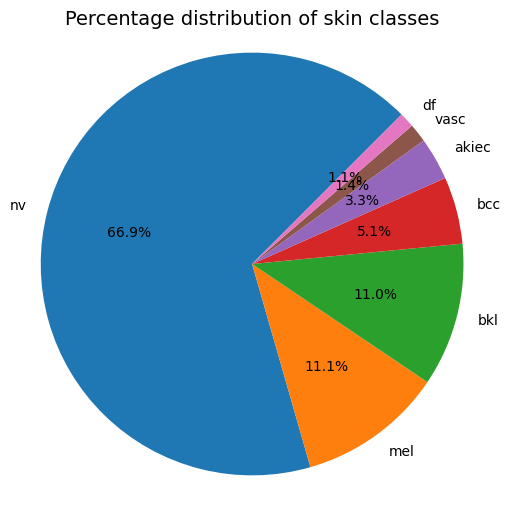

In [ ]:
plt.figure(figsize=(6,6))

counts =train_df["dx"].value_counts(dropna=False)
counts.plot.pie(autopct='%1.1f%%', shadow=False,
    startangle=45,  explode=[0, 0, 0, 0, 0,0,0]
)

plt.title('Percentage distribution of skin classes', fontsize=14)
plt. ylabel("")
plt.axis('equal')
plt.show()

In [ ]:
test_df = pd.read_csv(test_metadata)
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAMTEST_0000000,ISIC_0034524,nv,follow_up,40.0,female,back,vidir_molemax
1,HAMTEST_0000001,ISIC_0034525,nv,histo,70.0,male,abdomen,rosendahl
2,HAMTEST_0000002,ISIC_0034526,bkl,histo,70.0,male,back,rosendahl
3,HAMTEST_0000003,ISIC_0034527,nv,histo,35.0,male,trunk,vienna_dias
4,HAMTEST_0000004,ISIC_0034528,nv,follow_up,75.0,female,trunk,vidir_molemax


In [ ]:
name_dict = {
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevus',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratosis',
    'bkl': 'Benign keratosis',
    'df': 'Dermatofibroma',
    'vasc': 'Vascular lesion'
}

In [ ]:
label_dict = {
    'mel': '0',
    'nv': '1',
    'bcc': '2',
    'akiec': '3',
    'bkl': '4',
    'df': '5',
    'vasc': '6'
}

In [ ]:
train_df['name'] = train_df['dx'].map(name_dict.get)
train_df['label'] = train_df['dx'].map(label_dict.get)

In [ ]:
train_df.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,name,label
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,Actinic keratosis,3
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,Actinic keratosis,3
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,Actinic keratosis,3
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,Actinic keratosis,3
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back,vidir_modern,Melanoma,0


In [ ]:
test_df['name'] = test_df['dx'].map(name_dict.get)
test_df['label'] = test_df['dx'].map(label_dict.get)

In [ ]:
def load_images(image_ids, image_dir):
    images = []
    for image_id in image_ids:
        image_path = os.path.join(image_dir, image_id + '.jpg')
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        image = tf.keras.preprocessing.image.img_to_array(image)
        images.append(image)
    return np.array(images)

In [ ]:
sample_images = ['ISIC_0032787','ISIC_0032477','ISIC_0030684','ISIC_0032198','ISIC_0030687','ISIC_0032974']

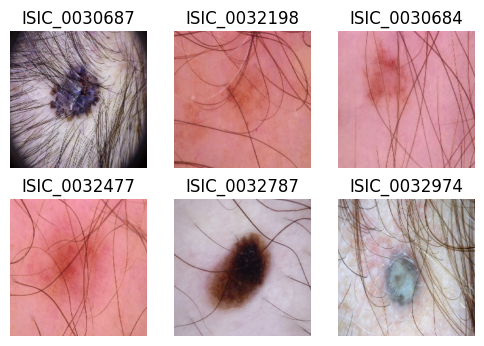

In [ ]:
# Image sample from 5 original skins
#sample_images = train_df.groupby('label')['image_id'].sample(1).tolist()
sample_images_df = train_df[train_df.image_id.isin(sample_images)]

# Load images
image_ids = sample_images_df.image_id.tolist()
images = load_images(image_ids, ori_train_images_dir)

# Display images
plt.figure(figsize=(6, 4))
for ind, (image_id, label, name, image) in enumerate(zip(sample_images_df.image_id, sample_images_df.label, sample_images_df.name, images)):
    plt.subplot(2, 3, ind + 1)
    plt.imshow(image.astype('int'))
    plt.title('{}'.format(image_id))
    plt.axis("off")

#plt.tight_layout()
plt.show()


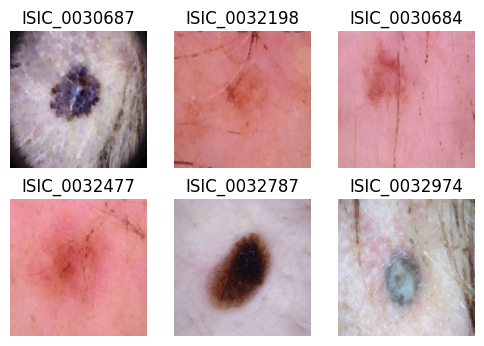

In [ ]:
# Image sample from 5 original skins
#sample_images = train_df.groupby('label')['image_id'].sample(1).tolist()
sample_images_df = train_df[train_df.image_id.isin(sample_images)]

# Load images
image_ids = sample_images_df.image_id.tolist()
images = load_images(image_ids, pro_train_images_dir)

# Display images
plt.figure(figsize=(6, 4))
for ind, (image_id, label, name, image) in enumerate(zip(sample_images_df.image_id, sample_images_df.label, sample_images_df.name, images)):
    plt.subplot(2, 3, ind + 1)
    plt.imshow(image.astype('int'))
    plt.title('{}'.format(image_id))
    plt.axis("off")

#plt.tight_layout()
plt.show()


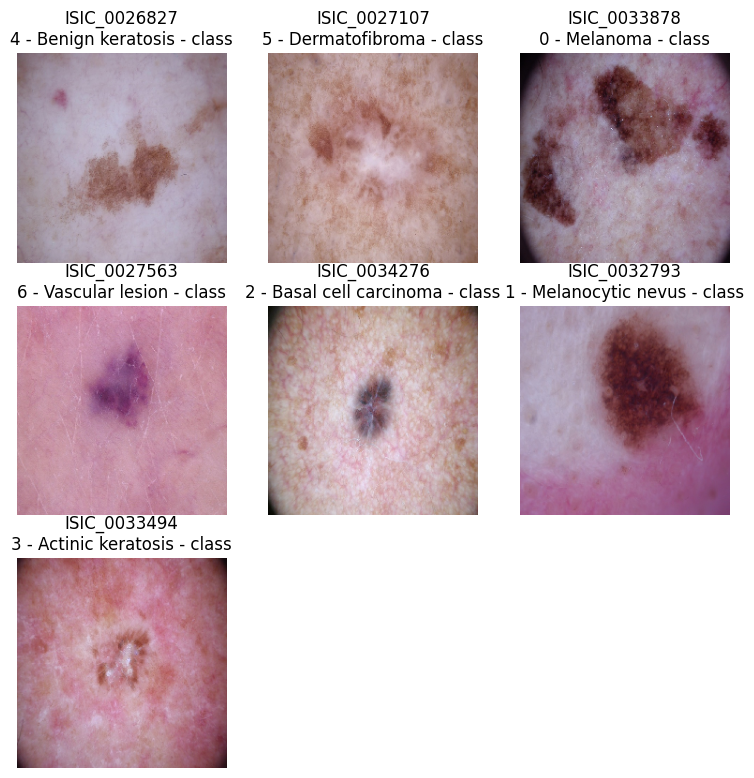

In [ ]:
# Image sample from 7 different classes
sample_images = train_df.groupby('label')['image_id'].sample(1).tolist()
sample_images_df = train_df[train_df.image_id.isin(sample_images)]

# Load images
image_ids = sample_images_df.image_id.tolist()
images = load_images(image_ids, pro_train_images_dir)

# Display images
plt.figure(figsize=(9.2, 9.3))
for ind, (image_id, label, name, image) in enumerate(zip(sample_images_df.image_id, sample_images_df.label, sample_images_df.name, images)):
    plt.subplot(3, 3, ind + 1)
    plt.imshow(image.astype('int'))
    plt.title('{}\n{} - {} - class'.format(image_id, label, name))
    plt.axis("off")

#plt.tight_layout()
plt.show()

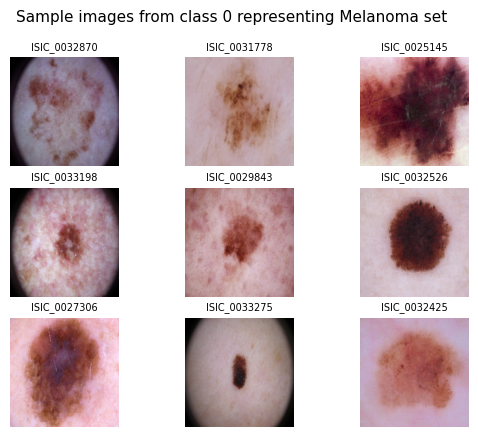

In [ ]:
sample = train_df[train_df['label'] == '0'].sample(9)

image_ids = sample.image_id.tolist()
images = load_images(image_ids, pro_train_images_dir)


for ind, (image_id, label, name, image) in enumerate(zip(sample.image_id, sample.label, sample.name, images)):
    plt.subplot(3, 3, ind + 1)
    plt.imshow(image.astype('int'))
    plt.title('{}'.format(image_id), fontsize=7)
    plt.axis("off")

plt.suptitle('Sample images from class {} representing {} set'.format(label,name), fontsize=11)
#plt.tight_layout()
plt.show()


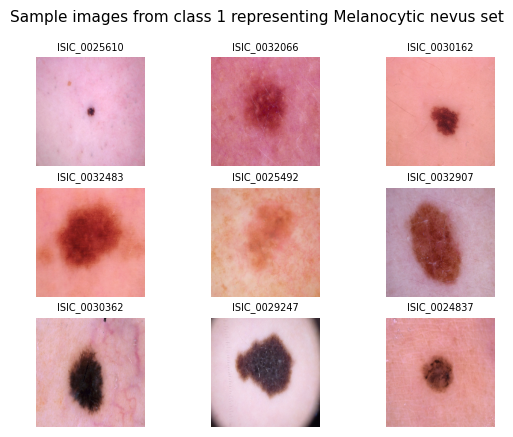

In [ ]:
sample = train_df[train_df['label'] == '1'].sample(9)

image_ids = sample.image_id.tolist()
images = load_images(image_ids, pro_train_images_dir)


for ind, (image_id, label, name, image) in enumerate(zip(sample.image_id, sample.label, sample.name, images)):
    plt.subplot(3, 3, ind + 1)
    plt.imshow(image.astype('int'))
    plt.title('{}'.format(image_id), fontsize=7)
    plt.axis("off")

plt.suptitle('Sample images from class {} representing {} set'.format(label,name), fontsize=11)
#plt.tight_layout()
plt.show()


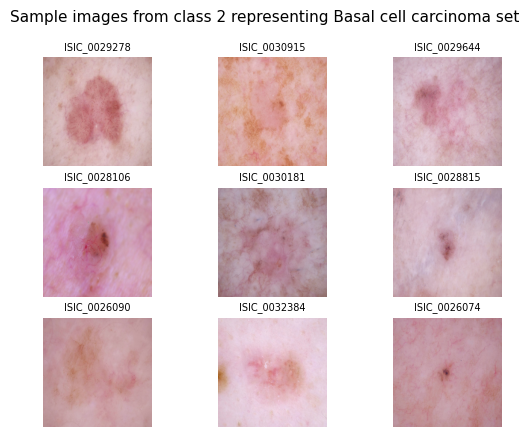

In [ ]:
sample = train_df[train_df['label'] == '2'].sample(9)

image_ids = sample.image_id.tolist()
images = load_images(image_ids, pro_train_images_dir)


for ind, (image_id, label, name, image) in enumerate(zip(sample.image_id, sample.label, sample.name, images)):
    plt.subplot(3, 3, ind + 1)
    plt.imshow(image.astype('int'))
    plt.title('{}'.format(image_id), fontsize=7)
    plt.axis("off")

plt.suptitle('Sample images from class {} representing {} set'.format(label,name), fontsize=11)
#plt.tight_layout()
plt.show()


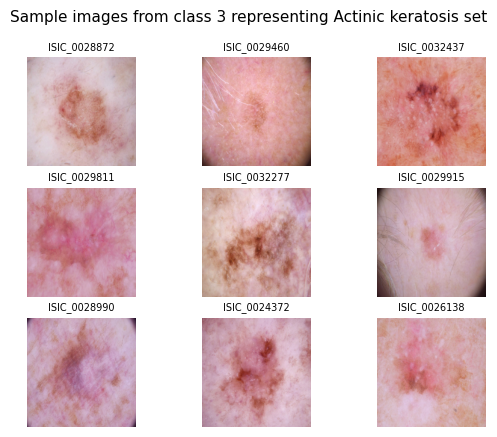

In [ ]:
sample = train_df[train_df['label'] == '3'].sample(9)

image_ids = sample.image_id.tolist()
images = load_images(image_ids, pro_train_images_dir)


for ind, (image_id, label, name, image) in enumerate(zip(sample.image_id, sample.label, sample.name, images)):
    plt.subplot(3, 3, ind + 1)
    plt.imshow(image.astype('int'))
    plt.title('{}'.format(image_id), fontsize=7)
    plt.axis("off")

plt.suptitle('Sample images from class {} representing {} set'.format(label,name), fontsize=11)
#plt.tight_layout()
plt.show()


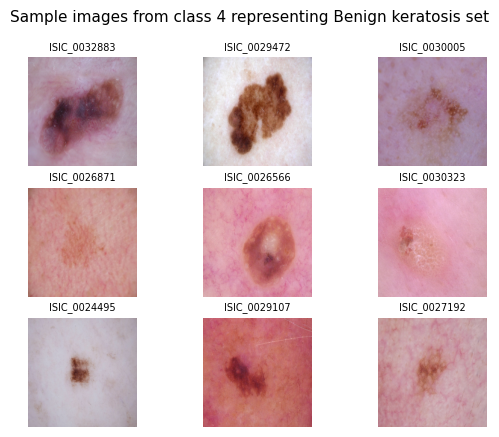

In [ ]:
sample = train_df[train_df['label'] == '4'].sample(9)

image_ids = sample.image_id.tolist()
images = load_images(image_ids, pro_train_images_dir)


for ind, (image_id, label, name, image) in enumerate(zip(sample.image_id, sample.label, sample.name, images)):
    plt.subplot(3, 3, ind + 1)
    plt.imshow(image.astype('int'))
    plt.title('{}'.format(image_id), fontsize=7)
    plt.axis("off")

plt.suptitle('Sample images from class {} representing {} set'.format(label,name), fontsize=11)
#plt.tight_layout()
plt.show()


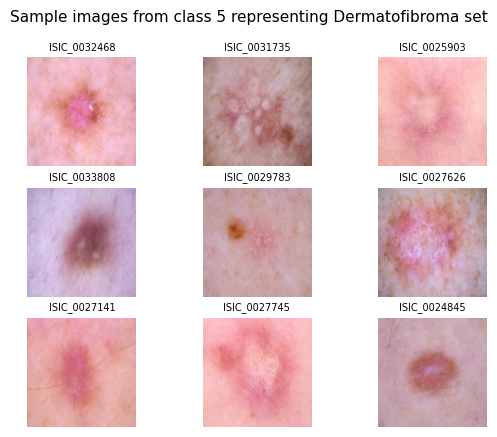

In [ ]:
sample = train_df[train_df['label'] == '5'].sample(9)

image_ids = sample.image_id.tolist()
images = load_images(image_ids, pro_train_images_dir)


for ind, (image_id, label, name, image) in enumerate(zip(sample.image_id, sample.label, sample.name, images)):
    plt.subplot(3, 3, ind + 1)
    plt.imshow(image.astype('int'))
    plt.title('{}'.format(image_id), fontsize=7)
    plt.axis("off")

plt.suptitle('Sample images from class {} representing {} set'.format(label,name), fontsize=11)
#plt.tight_layout()
plt.show()


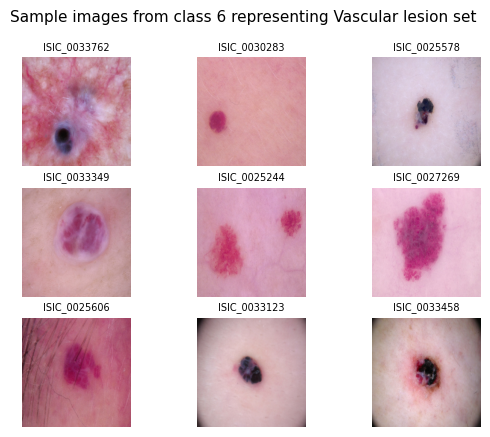

In [ ]:
sample = train_df[train_df['label'] == '6'].sample(9)

image_ids = sample.image_id.tolist()
images = load_images(image_ids, pro_train_images_dir)


for ind, (image_id, label, name, image) in enumerate(zip(sample.image_id, sample.label, sample.name, images)):
    plt.subplot(3, 3, ind + 1)
    plt.imshow(image.astype('int'))
    plt.title('{}'.format(image_id), fontsize=7)
    plt.axis("off")

plt.suptitle('Sample images from class {} representing {} set'.format(label,name), fontsize=11)
#plt.tight_layout()
plt.show()
